In [2]:
##Connecting to google drive and setting directory
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
!pip install -q findspark
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
import matplotlib.pyplot as plt
import findspark
import py4j
import pyspark
findspark.init()
print(pyspark.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=652f6528ae77cb61e5c064fa3502e06f22a6ad0c09838155a83e9b1db056c9c1
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
3.4.1


In [5]:
data_spark = SparkSession.builder.appName("EDA_and_Models").getOrCreate()
data_spark

In [4]:
# Import findspark to initialize Spark environment and pyspark.sql for Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Create a local Spark session and DataFrame, demonstrating data creation and display
spark = SparkSession.builder.master("local[*]").getOrCreate()
df = spark.createDataFrame([{"Hello World":"Let's create code"} for x in range(5)])

# Show the first three rows of the DataFrame without truncation
df.show(3, False)

+-----------------+
|Hello World      |
+-----------------+
|Let's create code|
|Let's create code|
|Let's create code|
+-----------------+
only showing top 3 rows



In [8]:
spark_df = data_spark.read.csv("/content/sample_data/Garments", header=True, inferSchema=True)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
spark_df = data_spark.read.csv("/content/sample_data/Garments", header=True, inferSchema=True)
df_gwp = spark_df.toPandas()

# Display the first few rows of the DataFrame
df_gwp.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


Attributes information
- date: Date in MM-DD-YYYY
- day: Day of the Week
- quarter: A portion of the month. A month was divided into four quarters
- department:	Associated department with the instance
- team_no: Associated team number with the instance
- no_of_workers: Number of workers in each team
- no_of_style_change: Number of changes in the style of a particular product
- targeted_productivity	: Targeted productivity set by the Authority for each team for each day.
- smv: Standard Minute Value, it is the allocated time for a task
- wip: Work in progress. Includes the number of unfinished items for products
- over_time: Represents the amount of overtime by each team in minutes
- incentive: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- idle_time: The amount of time when the production was interrupted due to several reasons
- idle_men:	The number of workers who were idle due to production interruption
- actual_productivity: The actual % of productivity that was delivered by the workers. It ranges from 0-1.

#DATA CLEAN

In [11]:
#Number of rows and columes
num_rows, num_columns = df_gwp.shape

# Print the number of rows and columns
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 1197
Number of columns: 15


In [12]:
#Percent of missing values by columns
missing_percent = df_gwp.isnull().sum() / len(df_gwp) * 100

missing_percent

date                      0.000000
quarter                   0.000000
department                0.000000
day                       0.000000
team                      0.000000
targeted_productivity     0.000000
smv                       0.000000
wip                      42.272348
over_time                 0.000000
incentive                 0.000000
idle_time                 0.000000
idle_men                  0.000000
no_of_style_change        0.000000
no_of_workers             0.000000
actual_productivity       0.000000
dtype: float64

wip has 42% missing values, we handle this issue by impute the colume by mean value

In [13]:
df_gwp.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int32
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int32
incentive                  int32
idle_time                float64
idle_men                   int32
no_of_style_change         int32
no_of_workers            float64
actual_productivity      float64
dtype: object

In [14]:
# Convert selected numeric-like columns to integers, handle missing values,
# and calculate the percentage of missing values for each column
df_gwp = df_gwp.apply(pd.to_numeric, errors='ignore', downcast='integer')

# List of columns to be converted and treated for missing values
columns_to_convert = ['team', 'targeted_productivity', 'smv', 'wip', 'over_time',
                      'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'actual_productivity']

# Convert specified columns to integers and handle missing values
for col in columns_to_convert:
    df_gwp[col] = pd.to_numeric(df_gwp[col], errors='ignore', downcast='integer')

# Calculate the mean value of 'wip' column and fill missing values with the mean
mean_value = df_gwp['wip'].mean()
df_gwp['wip'].fillna(mean_value, inplace=True)

# Calculate and display the percentage of missing values in each column
missing_percent = df_gwp.isnull().sum() / len(df_gwp) * 100
missing_percent


date                     0.0
quarter                  0.0
department               0.0
day                      0.0
team                     0.0
targeted_productivity    0.0
smv                      0.0
wip                      0.0
over_time                0.0
incentive                0.0
idle_time                0.0
idle_men                 0.0
no_of_style_change       0.0
no_of_workers            0.0
actual_productivity      0.0
dtype: float64

Now, all the attributes have no missing value. We can work on the next step - data preprocessing with descriptive analysis

In [15]:
#Handle the date colume
# Convert the date_column to datetime if it's not already a datetime dtype
df_gwp['date'] = pd.to_datetime(df_gwp['date'])

# Extract month and year from the datetime column as strings and numbers
df_gwp['month'] = df_gwp['date'].dt.strftime('%B')
df_gwp['year'] = df_gwp['date'].dt.strftime('%Y')

#Drop 'date' colume
df_gwp = df_gwp.drop('date', axis=1, inplace=False)

# Display the first few rows of the updated DataFrame
df_gwp.head()


,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month,year
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.000000,7080,98,0.0,0,0,59.0,0.940725,January,2015
1,Quarter1,finishing,Thursday,1,0.75,3.94,1190.465991,960,0,0.0,0,0,8.0,0.886500,January,2015
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5,0.800570,January,2015
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5,0.800570,January,2015
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.000000,1920,50,0.0,0,0,56.0,0.800382,January,2015


#DATA PREPROCESSING WITH DESCRIPTIVE ANALYSIS

**1. Statistical values**

In [16]:
df_gwp.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1395.647261,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1190.465991,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1190.465991,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


**2. Label distribution**

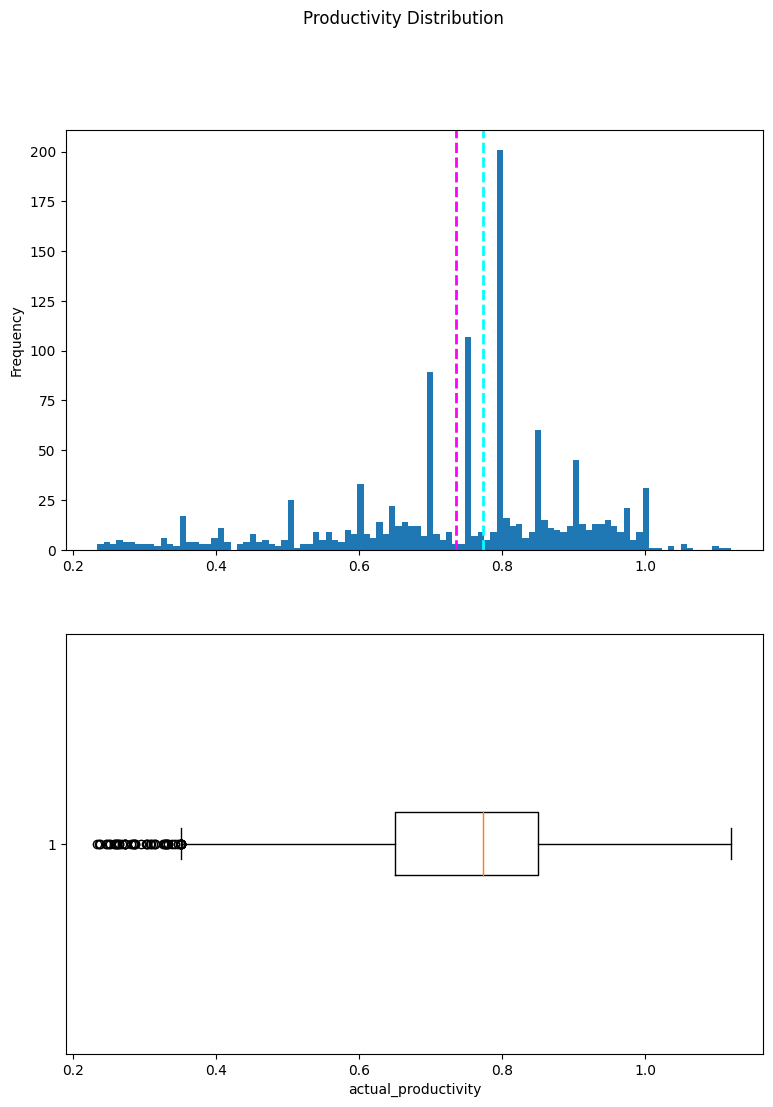

In [17]:
label = df_gwp['actual_productivity']

#create figure for 2 subplots
fig, ax = plt.subplots(2,1,figsize=(9,12))

#plot the histogram
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

#add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

#plot the boxplot
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('actual_productivity')

#add a title to the figure
fig.suptitle('Productivity Distribution')

fig.show()

**3. Features distribution**

In [18]:
numeric_features = ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change']

categorical_features = ['quarter', 'department', 'day', 'month']

***Numerical features***

<ipython-input-19-4d16a1f65dc9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_gwp.corr().round(1)


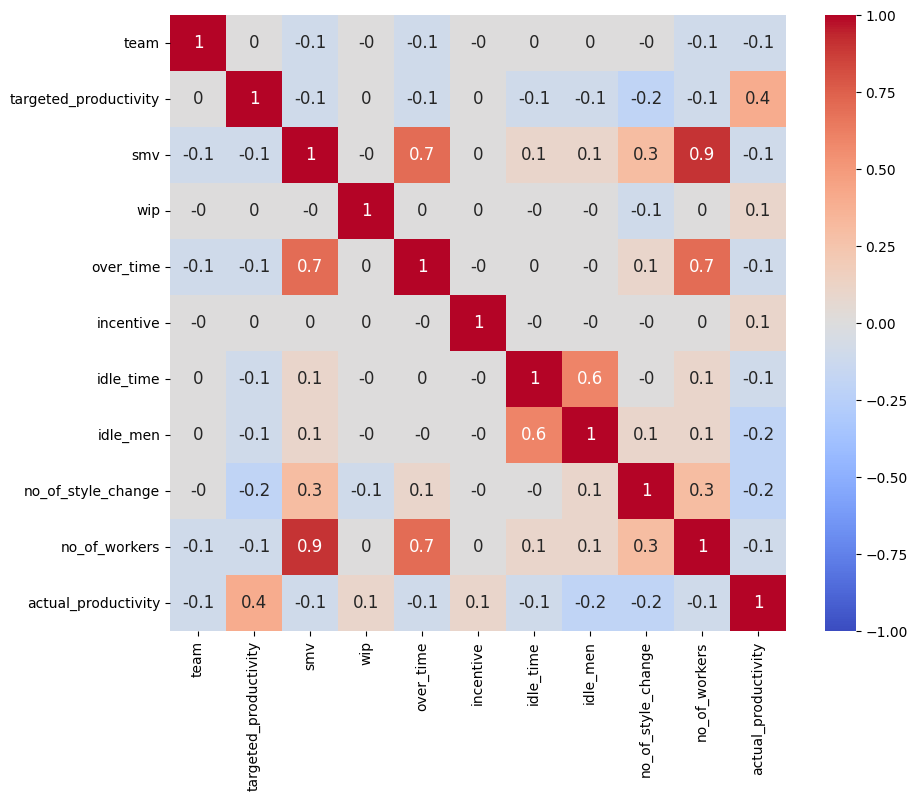

In [19]:
#plot the corr_matrix
corr_matrix = df_gwp.corr().round(1)

# Plot the matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, annot=True, annot_kws={"size": 12})
plt.show()

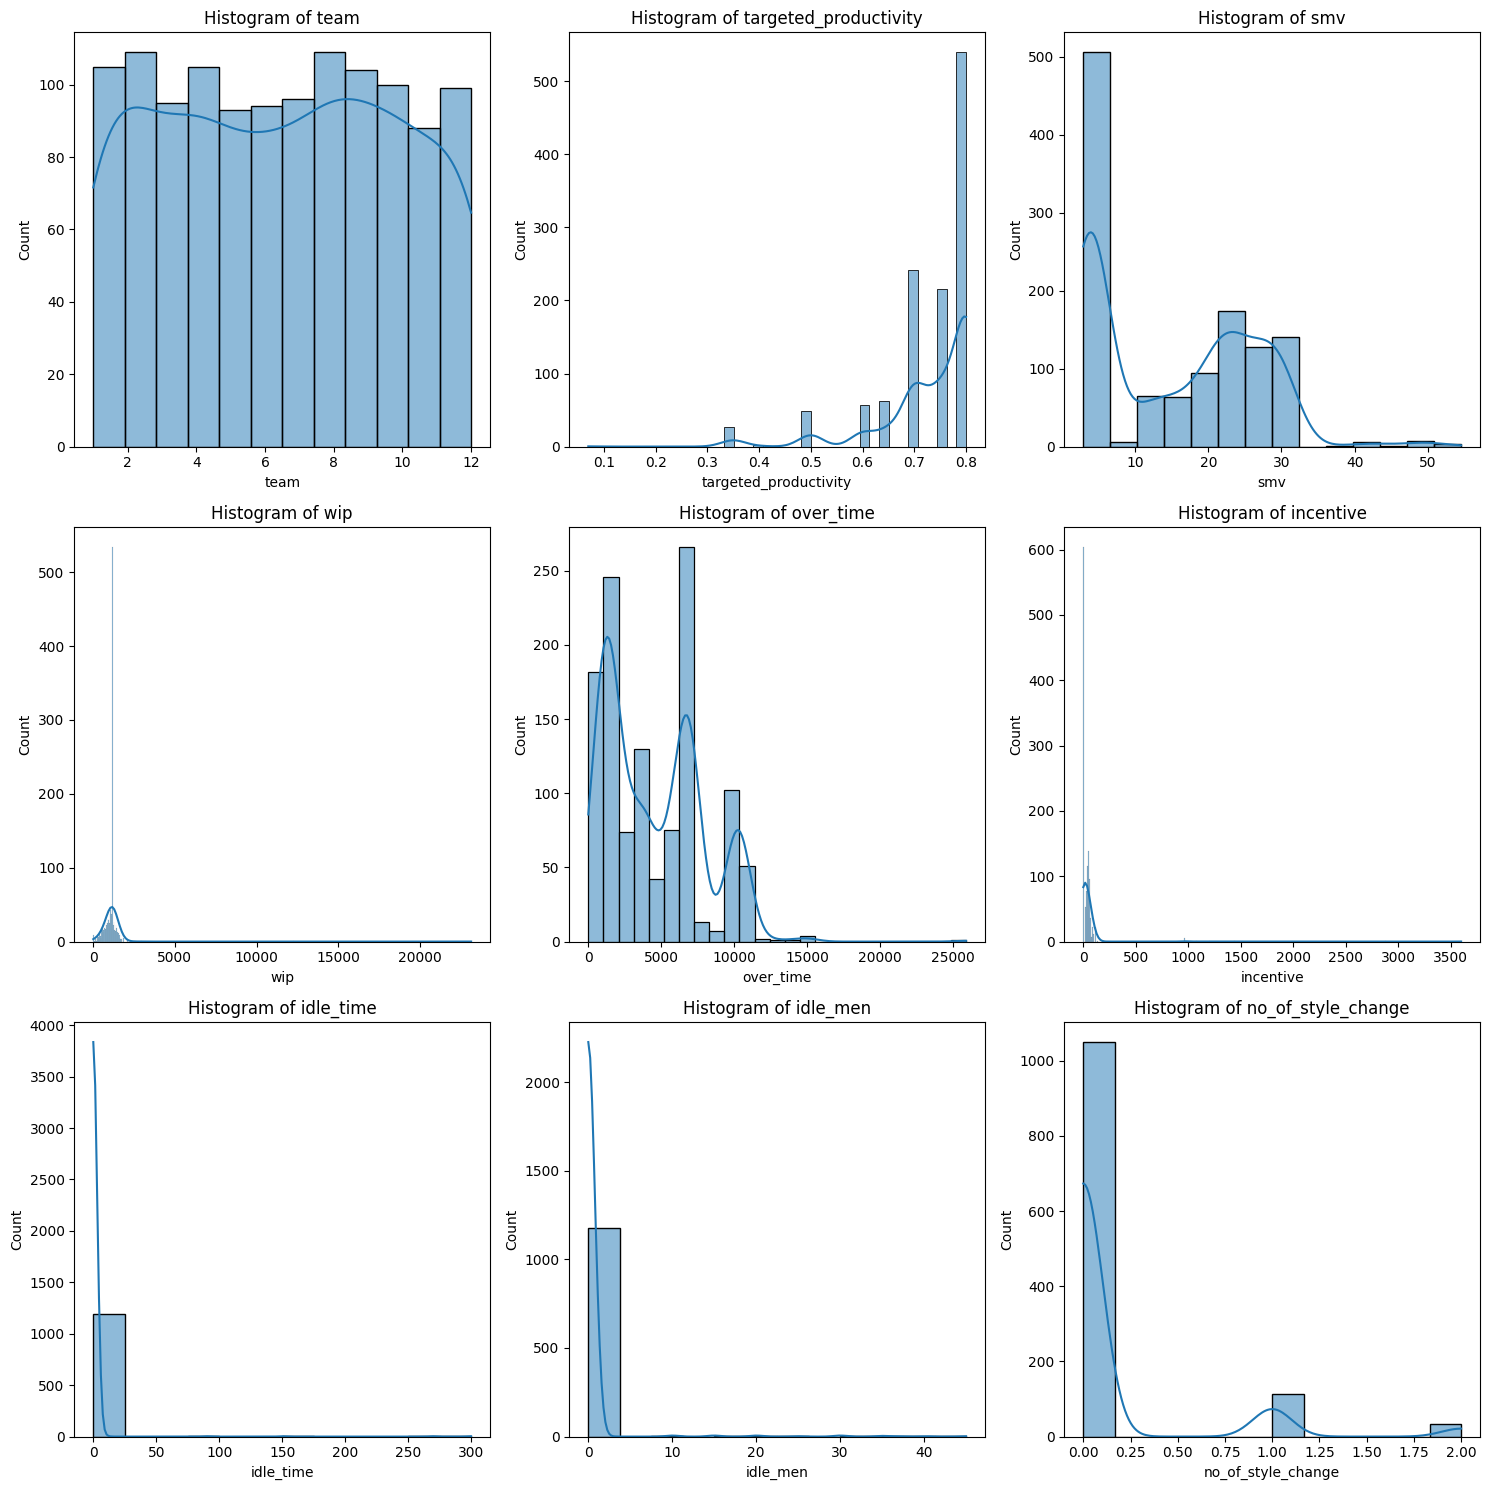

In [20]:
# Subplot grid
n_features = len(numeric_features)
n_cols = 3  # Customize the number of columns in the subplot grid
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

# Display the plot
for i, feature in enumerate(numeric_features):
    sns.histplot(ax=axes[i], data=df_gwp[feature], kde=True)
    axes[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()


***Categorical features***

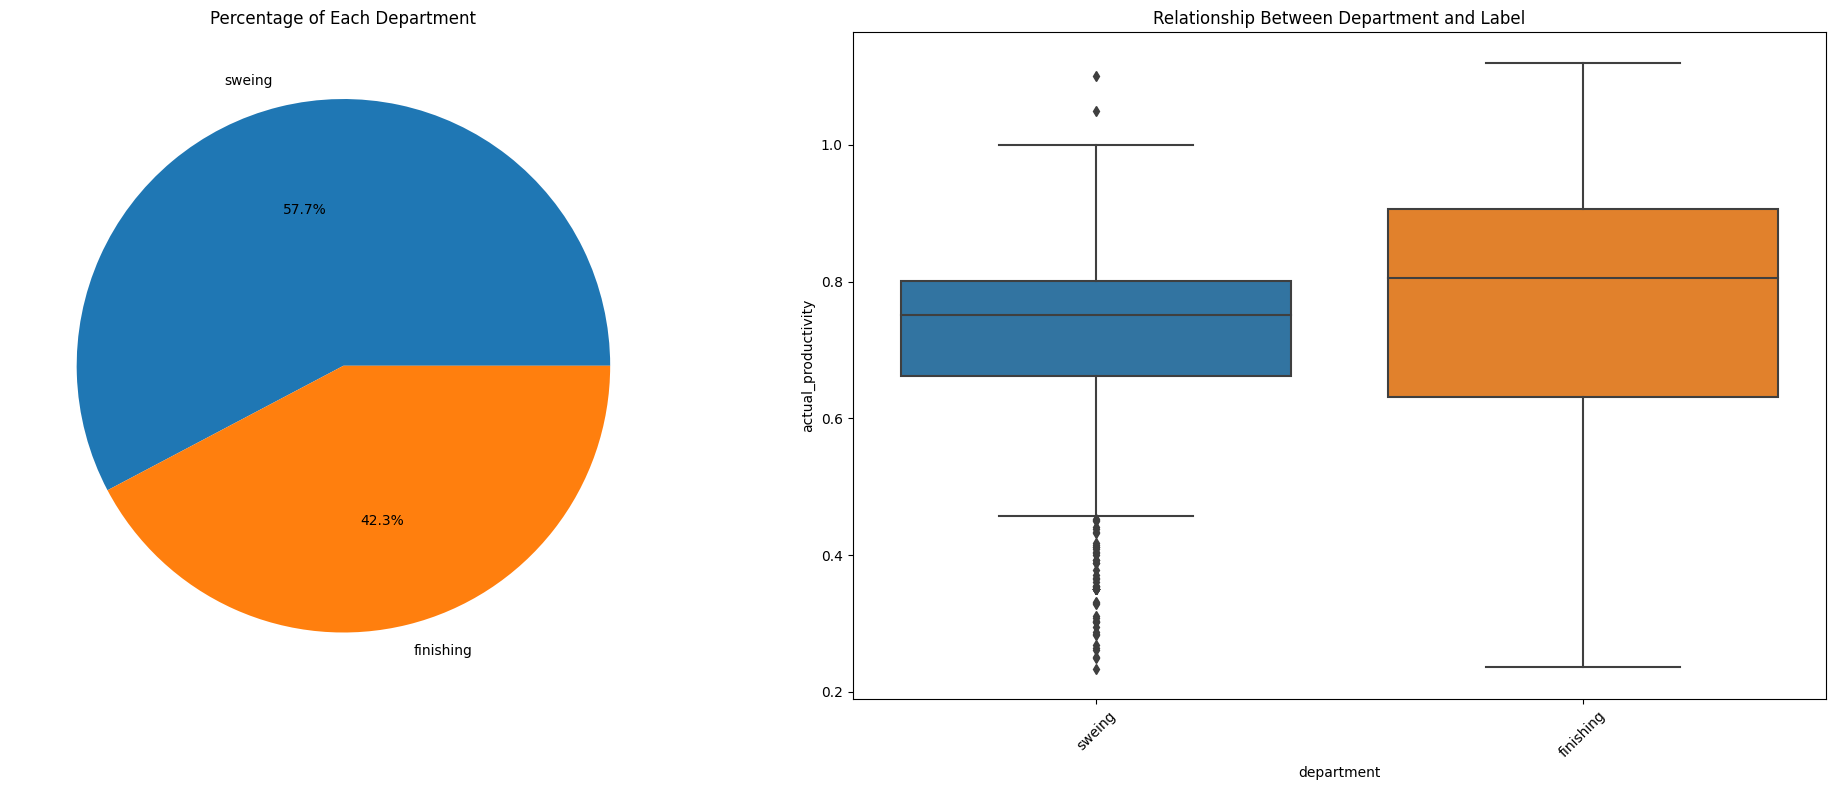

In [22]:
# Create a figure and a subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Pie chart showing the percentage of each department
df_gwp['department'] = df_gwp['department'].str.lower().str.strip()
no_of_departments = df_gwp['department'].value_counts()
axes[0].pie(no_of_departments, labels=no_of_departments.index, autopct='%.1f%%')
axes[0].set_title('Percentage of Each Department')

# The relationship between each department and the label
sns.boxplot(ax=axes[1], x='department', y=label, data=df_gwp)
axes[1].set_title('Relationship Between Department and Label')
axes[1].tick_params(axis='x', rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
no_of_departments

sweing       691
finishing    506
Name: department, dtype: int64

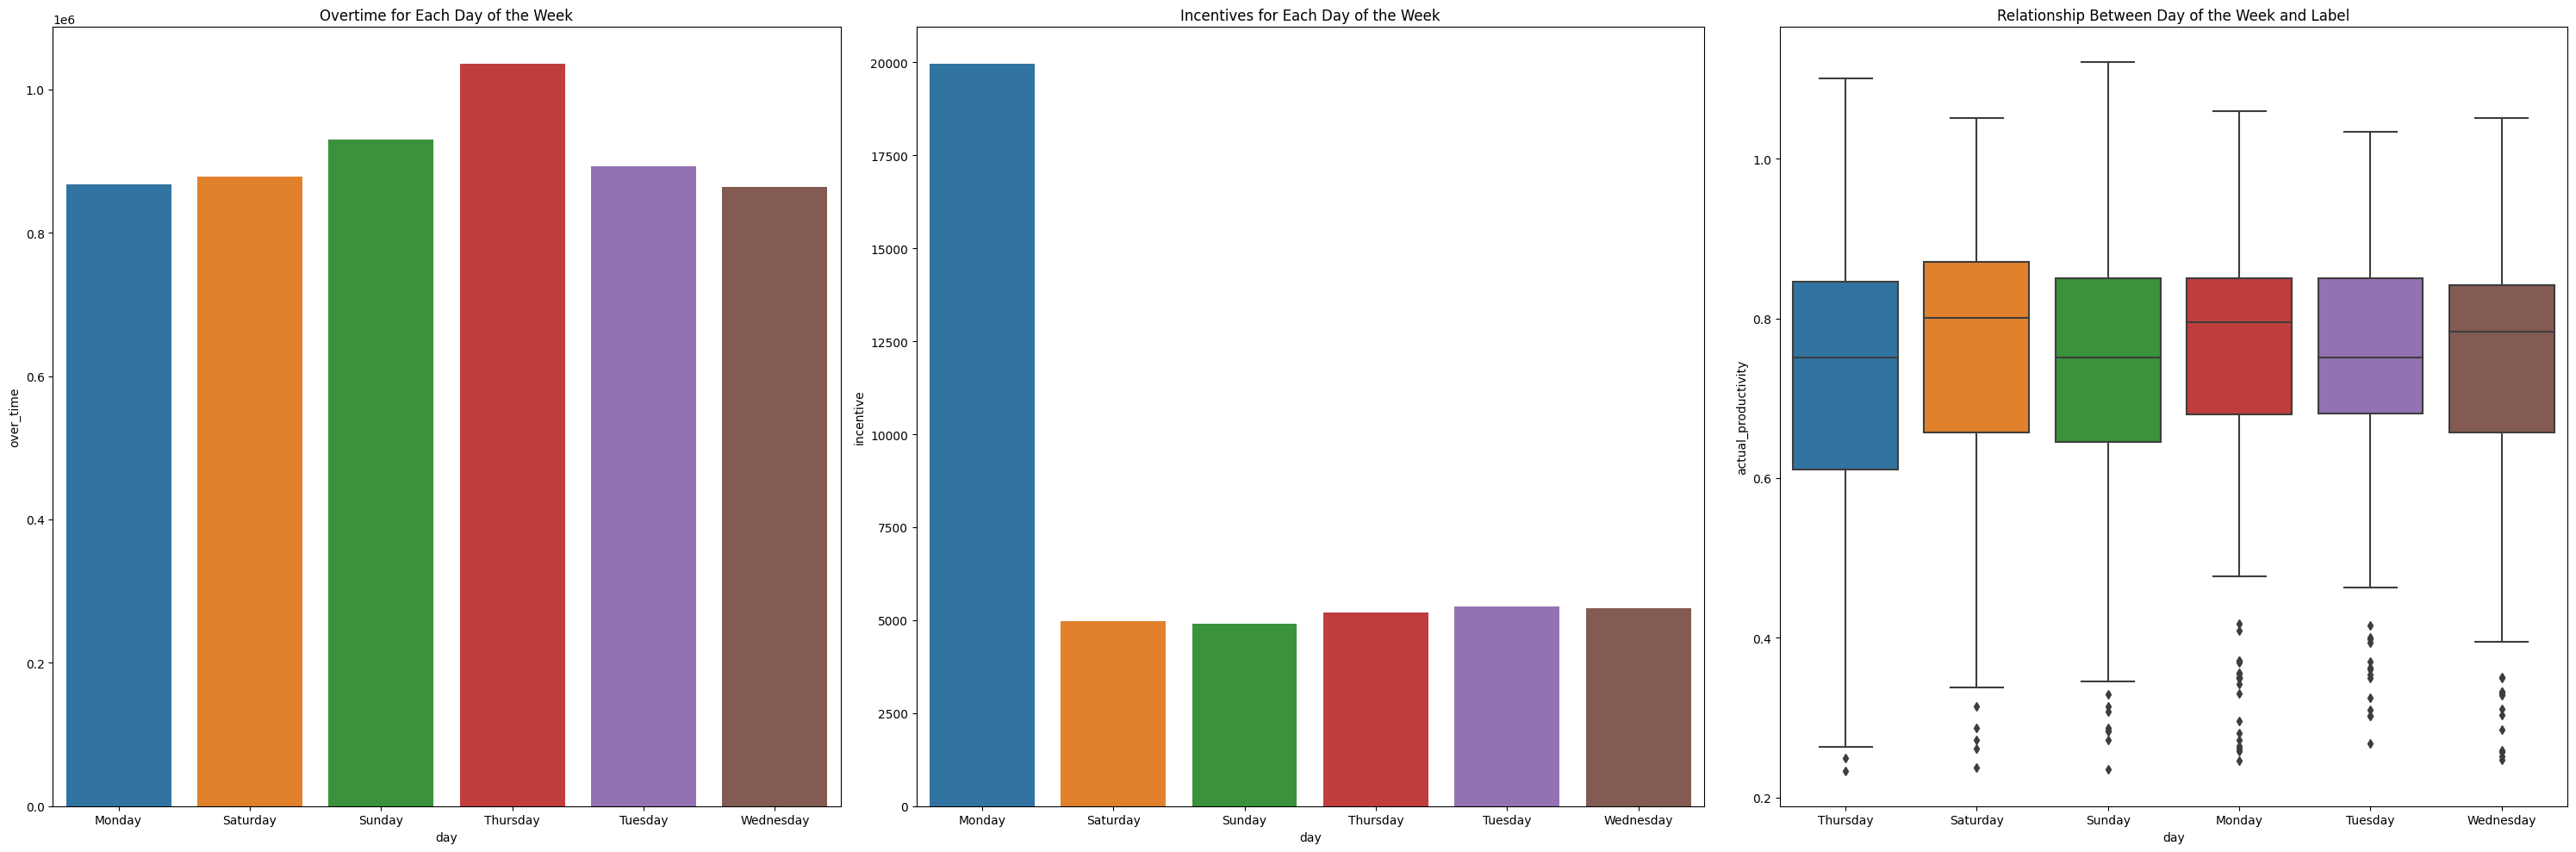

In [ ]:
# Group by day and aggregate over_time and incentive
data_day = df_gwp.groupby('day').agg({
    'over_time': 'sum',
    'incentive': 'sum'
}).reset_index()

# Subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

# Overtime in each day of the week
sns.barplot(ax=axes[0], x='day', y='over_time', data=data_day)
axes[0].set_title('Overtime for Each Day of the Week')

# Incentives in each day of the week
sns.barplot(ax=axes[1], x='day', y='incentive', data=data_day)
axes[1].set_title('Incentives for Each Day of the Week')

# The relationship between each day of week and label
sns.boxplot(ax=axes[2], x='day', y=label, data=df_gwp)
axes[2].set_title('Relationship Between Day of the Week and Label')

# Display the plot
plt.tight_layout()
plt.show()

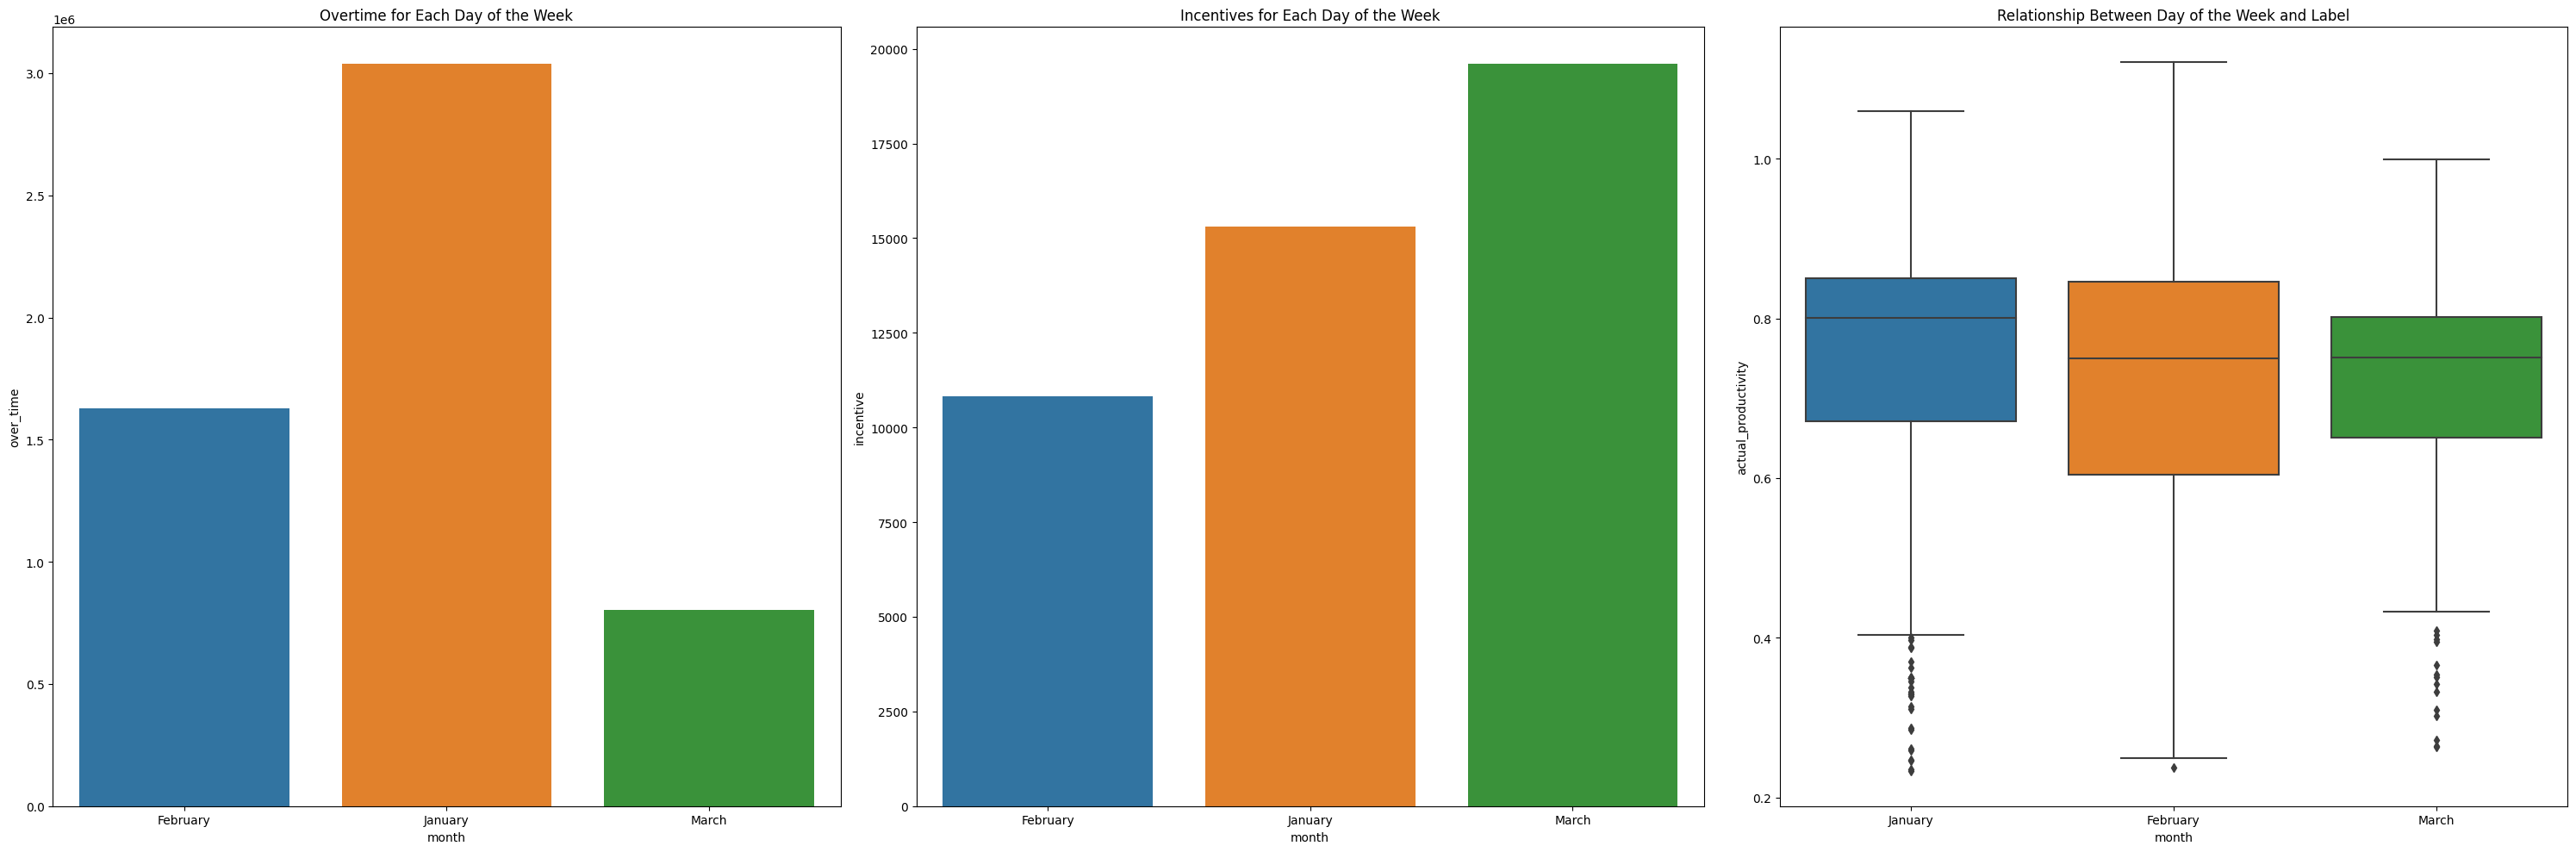

In [ ]:
# Group by day and aggregate over_time and incentive

data_day = df_gwp.groupby('month').agg({
    'over_time': 'sum',
    'incentive': 'sum'
}).reset_index()

# Subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

# Overtime in each day of the week
sns.barplot(ax=axes[0], x='month', y='over_time', data=data_day)
axes[0].set_title('Overtime for Each Day of the Week')

# Incentives in each day of the week
sns.barplot(ax=axes[1], x='month', y='incentive', data=data_day)
axes[1].set_title('Incentives for Each Day of the Week')

# The relationship between each day of week and label
sns.boxplot(ax=axes[2], x='month', y=label, data=df_gwp)
axes[2].set_title('Relationship Between Day of the Week and Label')

# Display the plot
plt.tight_layout()
plt.show()

***Target productivity and actual productivity***

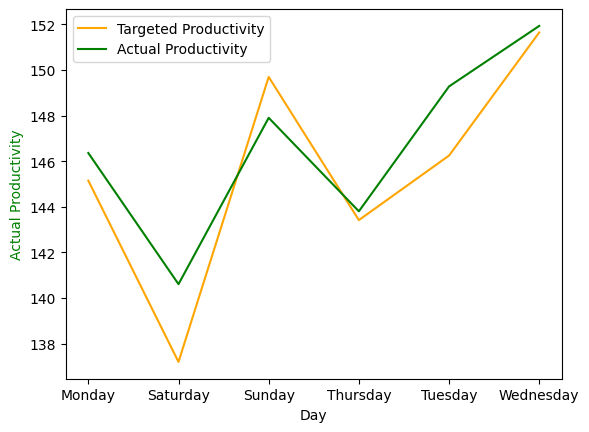

In [ ]:
#calculate targeted productivity grouped by day
sum_targeted_productivity = df_gwp.groupby([pd.Grouper(key='day')])['targeted_productivity'].sum()

#calculate actual productivity grouped by day
sum_actual_productivity = df_gwp.groupby([pd.Grouper(key='day')])['actual_productivity'].sum()

# create the figure and axis objects
fig, ax1 = plt.subplots()

# create the first line for targeted productivity
ax1.plot(sum_targeted_productivity, color='orange')
ax1.set_xlabel('Day')
ax1.set_ylabel('Targeted Productivity', color='orange')

# create the second line for actual productivity on the same axis
ax1.plot(sum_actual_productivity, color='green')
ax1.set_ylabel('Actual Productivity', color='green')

# create a legend
ax1.legend(['Targeted Productivity', 'Actual Productivity'])

# show the plot
plt.show()

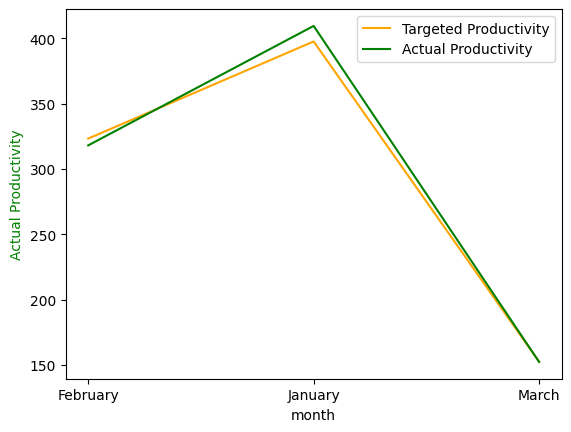

In [ ]:
#calculate targeted productivity grouped by day
sum_targeted_productivity = df_gwp.groupby([pd.Grouper(key='month')])['targeted_productivity'].sum()

#calculate actual productivity grouped by day
sum_actual_productivity = df_gwp.groupby([pd.Grouper(key='month')])['actual_productivity'].sum()

# create the figure and axis objects
fig, ax1 = plt.subplots()

# create the first line for targeted productivity
ax1.plot(sum_targeted_productivity, color='orange')
ax1.set_xlabel('month')
ax1.set_ylabel('Targeted Productivity', color='orange')

# create the second line for actual productivity on the same axis
ax1.plot(sum_actual_productivity, color='green')
ax1.set_ylabel('Actual Productivity', color='green')

# create a legend
ax1.legend(['Targeted Productivity', 'Actual Productivity'])

# show the plot
plt.show()

#DATA PREPROCESSING

In [25]:
spark_clean_df = data_spark.createDataFrame(df_gwp) # Convert Pandas DataFrame to PySpark DataFrame
spark_clean_df = spark_clean_df.drop("year")# remove unwanted column
spark_clean_df.select("actual_productivity").show(5)

+-------------------+
|actual_productivity|
+-------------------+
|        0.940725424|
|             0.8865|
|        0.800570492|
|        0.800570492|
|        0.800381944|
+-------------------+
only showing top 5 rows



In [26]:
from pyspark.sql.types import DoubleType, IntegerType

# Cast columns to appropriate data types
spark_clean_df = spark_clean_df.withColumn("team", spark_clean_df["team"].cast(IntegerType())) \
    .withColumn("no_of_workers", spark_clean_df["no_of_workers"].cast(IntegerType())) \
    .withColumn("no_of_style_change", spark_clean_df["no_of_style_change"].cast(IntegerType())) \
    .withColumn("targeted_productivity", spark_clean_df["targeted_productivity"].cast(DoubleType())) \
    .withColumn("smv", spark_clean_df["smv"].cast(DoubleType())) \
    .withColumn("wip", spark_clean_df["wip"].cast(DoubleType())) \
    .withColumn("over_time", spark_clean_df["over_time"].cast(IntegerType())) \
    .withColumn("incentive", spark_clean_df["incentive"].cast(DoubleType())) \
    .withColumn("idle_time", spark_clean_df["idle_time"].cast(DoubleType())) \
    .withColumn("idle_men", spark_clean_df["idle_men"].cast(IntegerType())) \
    .withColumn("actual_productivity", spark_clean_df["actual_productivity"].cast(DoubleType()))
#spark_clean_df.show(5)

In [27]:
spark_clean_df = spark_clean_df.drop("no_of_workers")# drop the column as it is to reduce multicollinearity affect

In [28]:
target = 'actual_productivity' # setting for target variable

In [29]:
# Spark categorical variables
dtypes = spark_clean_df.dtypes
cat_input = []
for i in range(0, len(spark_clean_df.columns)):
  if dtypes[i][1] == 'string': #identify categorical variable
    cat_input.append(dtypes[i][0])
cat_input = list(set(cat_input)-set(target)) # assigned only number types variable without target variable
#cat_input

In [30]:
# Spark numerical variables
num_input = list(set(spark_clean_df.columns) - set([target]) - set(cat_input)) # assigned only number types variable without target variable
#num_input

In [31]:
from pyspark.sql.functions import *
# final check for null value in Spark dataframe
null_counts = spark_clean_df.select([when(isnull(c), 1).otherwise(0).alias(c) for c in spark_clean_df.columns]).groupBy().sum()
print("Final check for null values:")
for column in spark_clean_df.columns:
    print(f"{column}: {null_counts.collect()[0][f'sum({column})']}")

Final check for null values:
quarter: 0
department: 0
day: 0
team: 0
targeted_productivity: 0
smv: 0
wip: 0
over_time: 0
incentive: 0
idle_time: 0
idle_men: 0
no_of_style_change: 0
actual_productivity: 0
month: 0


### Normalize Variables

In [32]:
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

In [33]:
class Standardizer(Transformer, HasInputCol, HasOutputCol):

    def __init__(self, inputCol=None, outputCol=None):
        super(Standardizer, self).__init__()
        self.setParams(inputCol = inputCol , outputCol = outputCol)

    def setParams(self, inputCol=None, outputCol=None):
      return self._set(inputCol = inputCol, outputCol = outputCol)

    def _transform(self, dataset):
      from pyspark.sql.functions import stddev, mean, col
      out_col = self.getOutputCol()
      in_col = dataset[self.getInputCol()]
      xmin, xmax = dataset.select(min(in_col), max(in_col)).first()
      return dataset.withColumn(out_col, (in_col - xmin)/(xmax-xmin))

In [43]:
# iterates the num_input list, transformer for each column and appending to standardizers list
#standardizers
standardizers = [Standardizer(inputCol = column, outputCol = column+"_standardized") for column in num_input]

##### Encode Dummy Variables

In [35]:
indexers = [StringIndexer(inputCol = column, outputCol = column+"_index") for column in cat_input]
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy") for column in cat_input]

##### Combine Stages

In [44]:
#from pyspark.ml.classification import *
import functools
import operator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [37]:
#input_cols
input_cols = []
for i in cat_input:
  input_cols.append(i+"_dummy")
for i in num_input:
  input_cols.append(i+"_standardized")


In [38]:
#stages
stages = []
assembler = VectorAssembler(inputCols= input_cols, outputCol="features") #concatenate all input variables and names as features [[0,1,0],30,20,40000]
stages = functools.reduce(operator.concat, [indexers, encoders, standardizers]) #indexers,  encoders, standardizers])
stages.append(assembler)


##### Create Spark Pipeline

In [39]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
spark_clean_df = pipeline.fit(spark_clean_df).transform(spark_clean_df)

# SPLIT TRAIN AND TEST SET

In [45]:
# 70% to the training and 30% to the testing set with random seed reproducibility.
train, test = spark_clean_df.randomSplit([0.7, 0.3], seed = 2008)


Training Dataset Count: 831
Test Dataset Count: 366


# MODEL FITTING

In [41]:
from pyspark.ml.regression import *
!pip install findspark

##### 1. Linear Regression

In [42]:
# create logistic regression
lr = LinearRegression(labelCol=target, featuresCol="features", maxIter=10) # Linear regressiion model with 10 maximum number of iteration for optimization algorithm.
lr_model = lr.fit(train)

#tranform model to test
lr_result = lr_model.transform(test)
lr_result.select('actual_productivity', 'prediction','features').show(5)

+-------------------+------------------+--------------------+
|actual_productivity|        prediction|            features|
+-------------------+------------------+--------------------+
|        0.804416667|0.8504620687719736|(21,[1,8,10,12,14...|
|        0.759270833|0.6912435101868645|(21,[1,8,10,12,17...|
|        0.561979167|0.6780678184758686|(21,[1,8,11,12,14...|
|        0.628333333|0.7978468527685867|(21,[1,10,12,17,1...|
|        0.956270833|0.7834810419831217|(21,[1,10,12,14,1...|
+-------------------+------------------+--------------------+
only showing top 5 rows



##### 2. Decision Tree

In [49]:
# create decision tree
dt = DecisionTreeRegressor(labelCol=target, featuresCol="features")
dt_model = dt.fit(train)

dt_result = dt_model.transform(test)
dt_result.select('actual_productivity', 'prediction', 'features').show(5)

+-------------------+------------------+--------------------+
|actual_productivity|        prediction|            features|
+-------------------+------------------+--------------------+
|        0.804416667|0.8383328188531468|(21,[1,8,10,12,14...|
|        0.759270833|      0.2721979165|(21,[1,8,10,12,17...|
|        0.561979167|0.7643031636585366|(21,[1,8,11,12,14...|
|        0.628333333|0.6148672348000002|(21,[1,10,12,17,1...|
|        0.956270833|0.7834105737172997|(21,[1,10,12,14,1...|
+-------------------+------------------+--------------------+
only showing top 5 rows



##### 3. Random Forest

In [50]:
# create random forest
rf = RandomForestRegressor(labelCol=target, featuresCol="features", numTrees=10) #random forest regression with 10 decision tree
rf_model = rf.fit(train)

rf_result = rf_model.transform(test)
rf_result.select('actual_productivity', 'prediction', 'features').show(5)

+-------------------+------------------+--------------------+
|actual_productivity|        prediction|            features|
+-------------------+------------------+--------------------+
|        0.804416667|0.7921656059913562|(21,[1,8,10,12,14...|
|        0.759270833|0.6934976651959472|(21,[1,8,10,12,17...|
|        0.561979167|0.7410115171496466|(21,[1,8,11,12,14...|
|        0.628333333| 0.697898709697572|(21,[1,10,12,17,1...|
|        0.956270833|0.7728084520013485|(21,[1,10,12,14,1...|
+-------------------+------------------+--------------------+
only showing top 5 rows



##### 4. Gradient Boosting

In [48]:
# create gradient boosting model to train set
gbt = GBTRegressor(labelCol=target, featuresCol="features", maxIter=10) #gradient boosted tree regressor with 10 maximum number of iteration for optimization algorithm
gbt_model = gbt.fit(train)

gbt_result = gbt_model.transform(test) #tranform model
gbt_result.select('actual_productivity', 'prediction','features').show(5)

+-------------------+-------------------+--------------------+
|actual_productivity|         prediction|            features|
+-------------------+-------------------+--------------------+
|        0.804416667| 0.8431485462383378|(21,[1,8,10,12,14...|
|        0.759270833|0.24168276423792662|(21,[1,8,10,12,17...|
|        0.561979167| 0.7641867795233477|(21,[1,8,11,12,14...|
|        0.628333333| 0.6109161018223294|(21,[1,10,12,17,1...|
|        0.956270833| 0.7746225739081029|(21,[1,10,12,14,1...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



# PERFORMANCE EVALUATION

#### Model Evaluation Metrics

In [51]:
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator

models = [lr_model, dt_model, rf_model, gbt_model]
model_names = ['Linear Regression','Decision Tree' ,'Random Forest', 'Gradient Boosting']

# define the metrics
metric_names = ['R2', 'RMSE', 'MSE', 'MAE']
metric_values = {name: [] for name in metric_names}

# calculate metrics for each model
for model, name in zip(models, model_names):
    # calculate R2
    r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="r2")
    r2 = r2_evaluator.evaluate(model.transform(test))
    metric_values['R2'].append(r2)

    # calculate RMSE
    rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="rmse")
    rmse = rmse_evaluator.evaluate(model.transform(test))
    metric_values['RMSE'].append(rmse)

    # calculate MSE
    mse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="mse")
    mse = mse_evaluator.evaluate(model.transform(test))
    metric_values['MSE'].append(mse)

    # calculate MAE
    mae_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=target, metricName="mae")
    mae = mae_evaluator.evaluate(model.transform(test))
    metric_values['MAE'].append(mae)

df_metrics = pd.DataFrame(metric_values, index=model_names)
print(df_metrics)


                         R2      RMSE       MSE       MAE
Linear Regression  0.238678  0.151503  0.022953  0.107396
Decision Tree      0.258218  0.149546  0.022364  0.097757
Random Forest      0.349829  0.140007  0.019602  0.094407
Gradient Boosting  0.271320  0.148219  0.021969  0.096034


The lowest RMSE, MSE, and MAE values, indicating the best overall performance models. R2 is response variable that exaplained by independent variables. In other words, it represents how well the model fits the data. In this case, Gradient Boosting is the best-performing model among evaluated models.

#### Model Evaluation Plots

In [52]:
actual_values = lr_result.select('actual_productivity').toPandas()

lr_predicted_values = lr_result.select('prediction').toPandas()
dt_predicted_values = dt_result.select('prediction').toPandas()
rf_predicted_values = rf_result.select('prediction').toPandas()
gbt_predicted_values = gbt_result.select('prediction').toPandas()


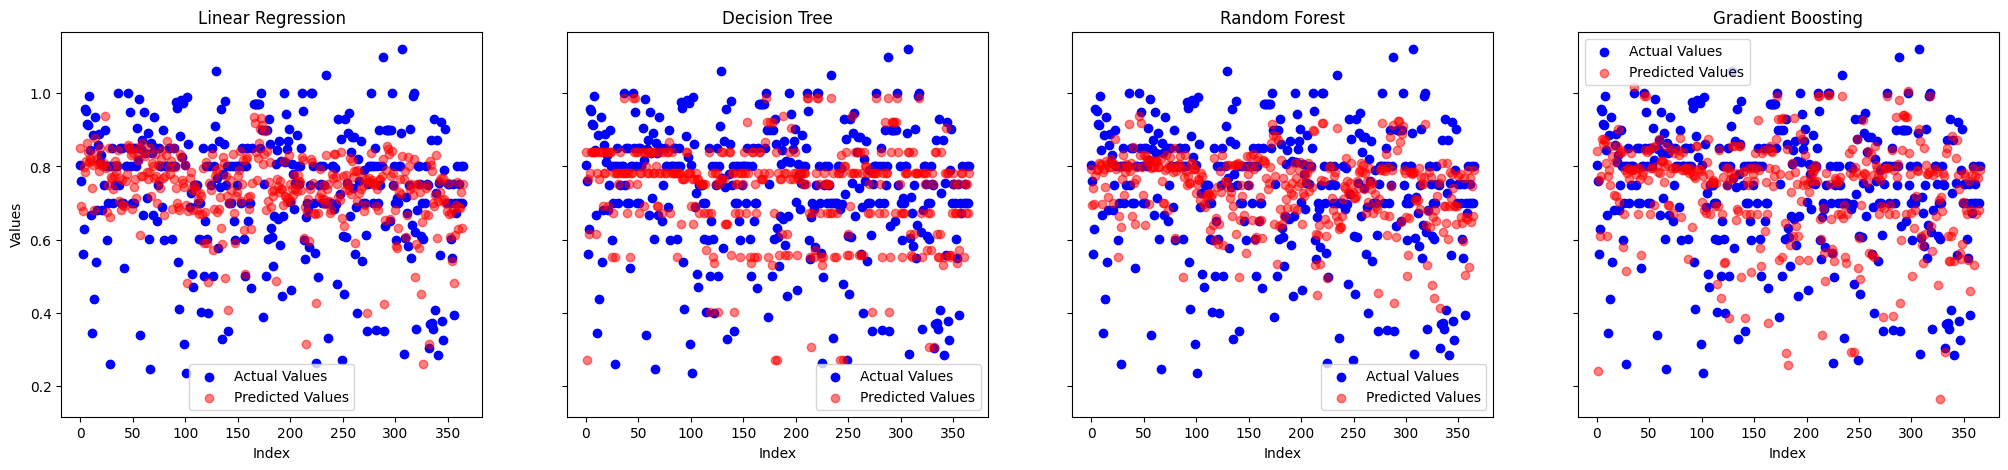

In [53]:
import numpy as np

# Create an array of index values for the x-axis
index_values = np.arange(len(actual_values))

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(25, 5), sharey=True)

# Linear Regression plot
axes[0].scatter(index_values, actual_values, color='blue', label='Actual Values')
axes[0].scatter(index_values, lr_predicted_values, color='red', label='Predicted Values', alpha=0.5)
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Values')
axes[0].set_title('Linear Regression')
axes[0].legend()

# Decision Tree plot
axes[1].scatter(index_values, actual_values, color='blue', label='Actual Values')
axes[1].scatter(index_values, dt_predicted_values, color='red', label='Predicted Values', alpha=0.5)
axes[1].set_xlabel('Index')
axes[1].set_title('Decision Tree')
axes[1].legend()

# Random Forest plot
axes[2].scatter(index_values, actual_values, color='blue', label='Actual Values')
axes[2].scatter(index_values, rf_predicted_values, color='red', label='Predicted Values', alpha=0.5)
axes[2].set_xlabel('Index')
axes[2].set_title('Random Forest')
axes[2].legend()

# Gradient Boosting plot
axes[3].scatter(index_values, actual_values, color='blue', label='Actual Values')
axes[3].scatter(index_values, gbt_predicted_values, color='red', label='Predicted Values', alpha=0.5)
axes[3].set_xlabel('Index')
axes[3].set_title('Gradient Boosting')
axes[3].legend()

plt.show()

#### Model Residual Plots

In [54]:
# Calculate residuals
lr_residuals_df = lr_result.withColumn('residuals', lr_result.actual_productivity - lr_result.prediction)
dt_residuals_df = dt_result.withColumn('residuals', dt_result.actual_productivity - dt_result.prediction)
rf_residuals_df = rf_result.withColumn('residuals', rf_result.actual_productivity - rf_result.prediction)
gbt_residuals_df = gbt_result.withColumn('residuals', gbt_result.actual_productivity - gbt_result.prediction)

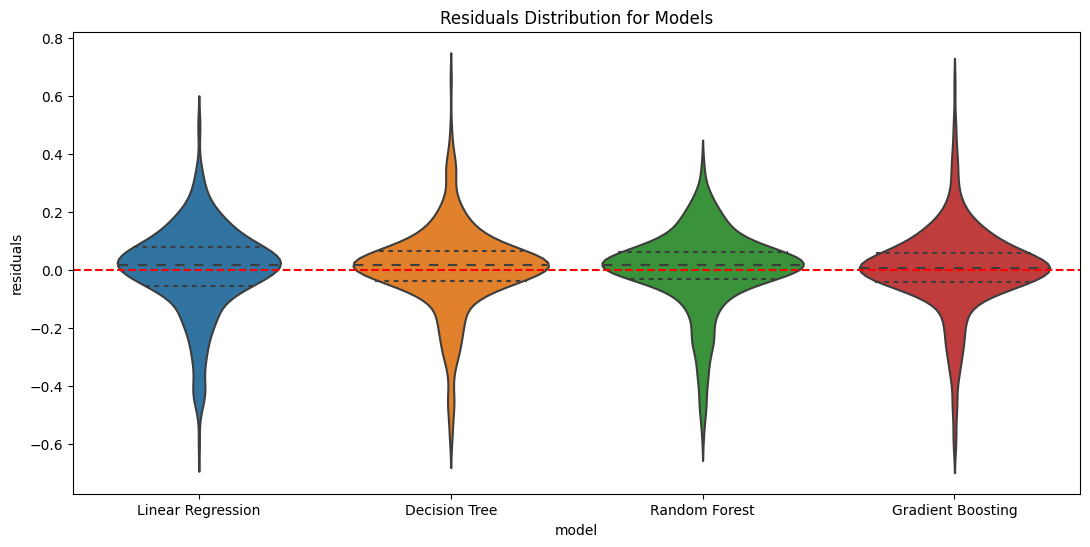

In [55]:
import seaborn as sns

# Convert residuals to Pandas
lr_residuals = lr_residuals_df.select('residuals').toPandas()
dt_residuals = dt_residuals_df.select('residuals').toPandas()
rf_residuals = rf_residuals_df.select('residuals').toPandas()
gbt_residuals = gbt_residuals_df.select('residuals').toPandas()

# Create combined DataFrame for plotting
residuals_df = pd.concat([
    lr_residuals.assign(model='Linear Regression'),
    dt_residuals.assign(model='Decision Tree'),
    rf_residuals.assign(model='Random Forest'),
    gbt_residuals.assign(model='Gradient Boosting')
], ignore_index=True)

# Create violin plot
plt.figure(figsize=(13, 6))
sns.violinplot(data=residuals_df, x='model', y='residuals', inner='quartile')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Distribution for Models')
plt.show()


Residual distribution is approximately symmetrical around zero, which indicates that the model predictions are likely to be above or below the actual productivity values.
Quartile lines inside the violin indicate the range of the residuals, and the red dashed line represents the zero line, which indicates that model predicted the actual productivity value perfectly.

#### Residuals

In [ ]:
from pyspark.sql.functions import mean, stddev, min, max

# Calculate residuals summary statistics for models
lr_summary_df = lr_residuals_df.select(mean('residuals').alias('mean'), stddev('residuals').alias('stddev'), min('residuals').alias('min'), max('residuals').alias('max'))
dt_summary_df = dt_residuals_df.select(mean('residuals').alias('mean'), stddev('residuals').alias('stddev'), min('residuals').alias('min'), max('residuals').alias('max'))
rf_summary_df = rf_residuals_df.select(mean('residuals').alias('mean'), stddev('residuals').alias('stddev'), min('residuals').alias('min'), max('residuals').alias('max'))
gbt_summary_df = gbt_residuals_df.select(mean('residuals').alias('mean'), stddev('residuals').alias('stddev'), min('residuals').alias('min'), max('residuals').alias('max'))

# print residuals summary statistics for models
print("Linear Regression Residuals:")
lr_summary_df.show()
print("Decision Tree Residuals:")
dt_summary_df.show()
print("Random Forest Residuals:")
rf_summary_df.show()
print("Gradient Boosting Residuals:")
gbt_summary_df.show()

Linear Regression Residuals:
+--------------------+------------------+-------------------+------------------+
|                mean|            stddev|                min|               max|
+--------------------+------------------+-------------------+------------------+
|9.353899839837781E-6|0.1517102305304102|-0.6024499008685547|0.5071140846768218|
+--------------------+------------------+-------------------+------------------+

Decision Tree Residuals:
+--------------------+-------------------+-------------------+------------------+
|                mean|             stddev|                min|               max|
+--------------------+-------------------+-------------------+------------------+
|0.005320424837535273|0.15130589156802682|-0.5910168018531468|0.6566520834999999|
+--------------------+-------------------+-------------------+------------------+

Random Forest Residuals:
+--------------------+-------------------+-------------------+-------------------+
|                mean

Overall models, the mean of the residuals is very close to zero and standard deviation is small, which indicates that the models are performing well in terms of predicting (actual productivity) values.